# Author: Стурейко Игорь
## Project: Geekbrains.Algorithms
## Lesson 05 - Случайный лес
## Date: 2020-09-07

## Реализация случайного леса

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

In [2]:
class Node:

    INSTANCE = 0
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        Node.INSTANCE += 1

    def __del__(self):
        Node.INSTANCE -= 1

In [3]:
class Leaf:
    INSTANCE = 0

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        Leaf.INSTANCE += 1
        self.prediction = self.predict()

    def __del__(self):
        Leaf.INSTANCE -= 1

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [4]:
class ForestTree:
    def __init__(self, criteria='gini'):
        self.criteria = criteria
        self.Node = None

    @staticmethod
    def gini(labels: np.array) -> float:
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity

    @staticmethod
    def entropia(labels: np.array) -> float:
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p * np.log2(p)

        return impurity

    def quality(self, left_labels, right_labels, current_informations):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        if self.criteria == 'entropia':
            return current_informations - p * self.entropia(left_labels) - (1 - p) * self.entropia(right_labels)
        else:
            return current_informations - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)

    @staticmethod
    def split(data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels

    @staticmethod
    def get_subsample(len_sample):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(len_sample)]

        len_subsample = int(np.sqrt(len_sample))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample

    def find_best_split(self, data, labels):

        #  обозначим минимальное количество объектов в узле
        min_leaf = 1

        if self.criteria == 'entropia':
            current_informations = self.entropia(labels)
        else:
            current_informations = self.gini(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self.get_subsample(n_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, current_informations)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def build_tree(self, data, labels):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

#         # Если достигли ограничения по количеству листьев - прекращаем рекурсию
#         if Leaf.INSTANCE >= self.max_leaf:
#             return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)

    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def predict(self, data):
        """
        Выполнить предсказание
        """
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.Node)
            classes.append(prediction)
        return np.array(classes)

    def fit(self, train_data, train_labels):
        self.Node = self.build_tree(train_data, train_labels)

In [5]:
class RandomForest:
    def __init__(self, n_trees):
        self.n_trees = n_trees
        self.forest = None

    def fit(self, data, labels):
        self.forest = []
        bootstrap = get_bootstrap(data, labels, self.n_trees)

        for b_data, b_labels in bootstrap:
            tree = ForestTree(criteria='gini')
            tree.fit(b_data, b_labels)
            self.forest.append(tree)

        return self.forest

    def tree_vote(self, data):

        # добавим предсказания всех деревьев в список
        predictions = []
        if not self.forest:
            raise NotFittedError(
                "This DecisionTreeClassifier instance is not fitted yet. "
                "Call 'fit' with appropriate arguments before using this estimator."
            )

        for tree in self.forest:
            predictions.append(tree.predict(data))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        return voted_predictions

In [6]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        for j in range(n_samples):
            sample_index = random.randint(0, n_samples - 1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))

    return bootstrap

In [7]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Применение модели

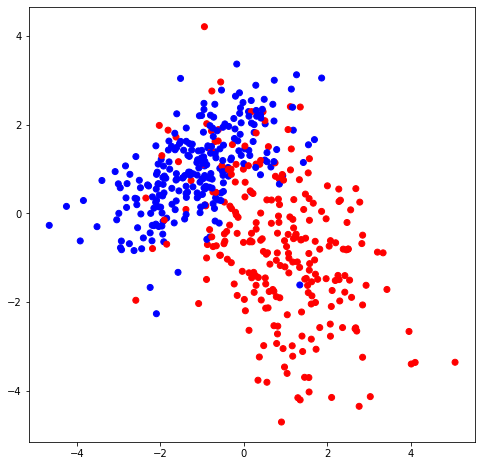

In [8]:
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                                              n_features=5, n_informative=5,
                                                                              n_classes=2, n_redundant=0,
                                                                              n_clusters_per_class=1, random_state=23)
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                random_state=1)

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)


In [9]:
n_trees = 1

my_forest_1 = RandomForest(n_trees=n_trees)
my_forest_1.fit(train_data, train_labels)
train_answers = my_forest_1.tree_vote(train_data)
test_answers = my_forest_1.tree_vote(test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print('\n\nRandom forest\n')
print(f' Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f' Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')





Random forest

 Точность случайного леса из 1 деревьев на обучающей выборке: 94.286
 Точность случайного леса из 1 деревьев на тестовой выборке: 92.000


In [10]:
n_trees = 5

my_forest_1 = RandomForest(n_trees=n_trees)
my_forest_1.fit(train_data, train_labels)
train_answers = my_forest_1.tree_vote(train_data)
test_answers = my_forest_1.tree_vote(test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print('\n\nRandom forest\n')
print(f' Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f' Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')





Random forest

 Точность случайного леса из 5 деревьев на обучающей выборке: 99.429
 Точность случайного леса из 5 деревьев на тестовой выборке: 92.667


In [11]:
n_trees = 10

my_forest_1 = RandomForest(n_trees=n_trees)
my_forest_1.fit(train_data, train_labels)
train_answers = my_forest_1.tree_vote(train_data)
test_answers = my_forest_1.tree_vote(test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print('\n\nRandom forest\n')
print(f' Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f' Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')





Random forest

 Точность случайного леса из 10 деревьев на обучающей выборке: 99.714
 Точность случайного леса из 10 деревьев на тестовой выборке: 97.333


In [12]:
n_trees = 20

my_forest_1 = RandomForest(n_trees=n_trees)
my_forest_1.fit(train_data, train_labels)
train_answers = my_forest_1.tree_vote(train_data)
test_answers = my_forest_1.tree_vote(test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print('\n\nRandom forest\n')
print(f' Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f' Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')





Random forest

 Точность случайного леса из 20 деревьев на обучающей выборке: 100.000
 Точность случайного леса из 20 деревьев на тестовой выборке: 95.333


## Задание 1.

Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [13]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                                              n_features=2, n_informative=2,
                                                                              n_classes=2, n_redundant=0,
                                                                              n_clusters_per_class=1, random_state=23)
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                random_state=1)



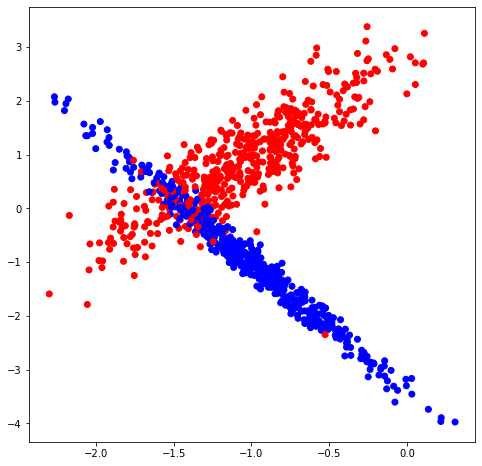

In [14]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [15]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [39]:
def plot_forest(n_trees):
#     n_trees = 1

    my_forest = RandomForest(n_trees=n_trees)
    my_forest.fit(train_data, train_labels)
    train_answers = my_forest.tree_vote(train_data)
    test_answers = my_forest.tree_vote(test_data)
    
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)

    plt.figure(figsize = (16, 7))
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])

    # график обучающей выборки
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(my_forest.tree_vote(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)


    plt.subplot(1,2,1)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}, number of trees = {n_trees}')

    # # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}, number of trees = {n_trees}')

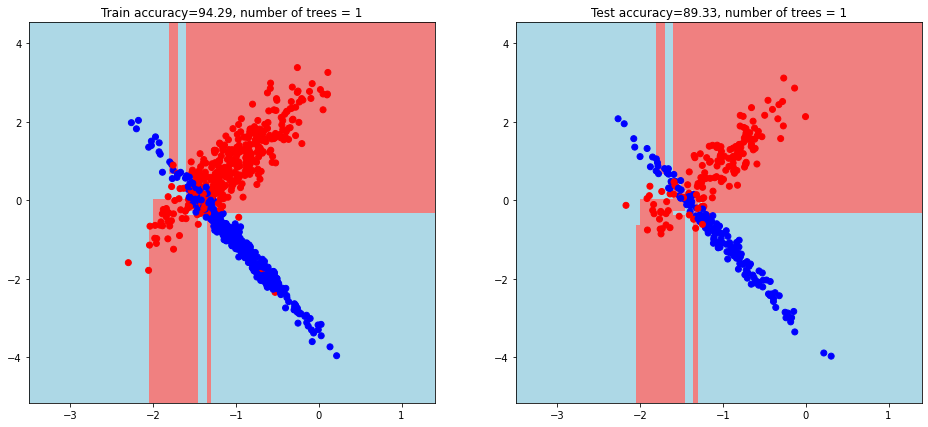

In [40]:
plot_forest(1)

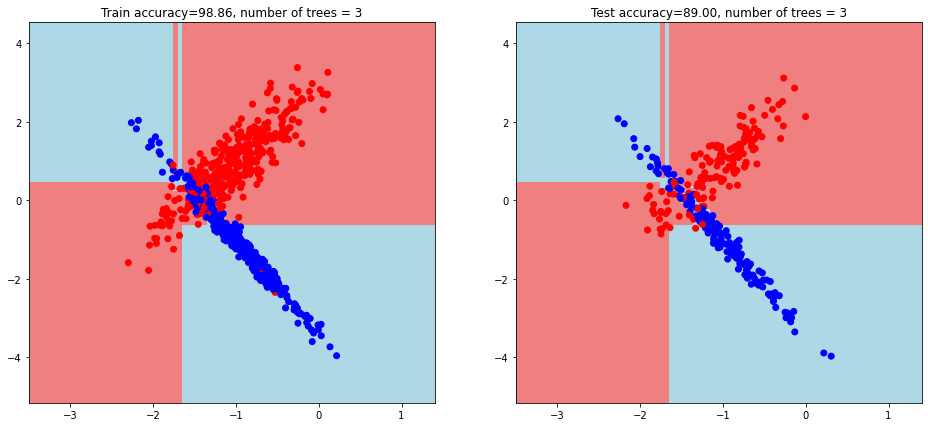

In [41]:
plot_forest(3)

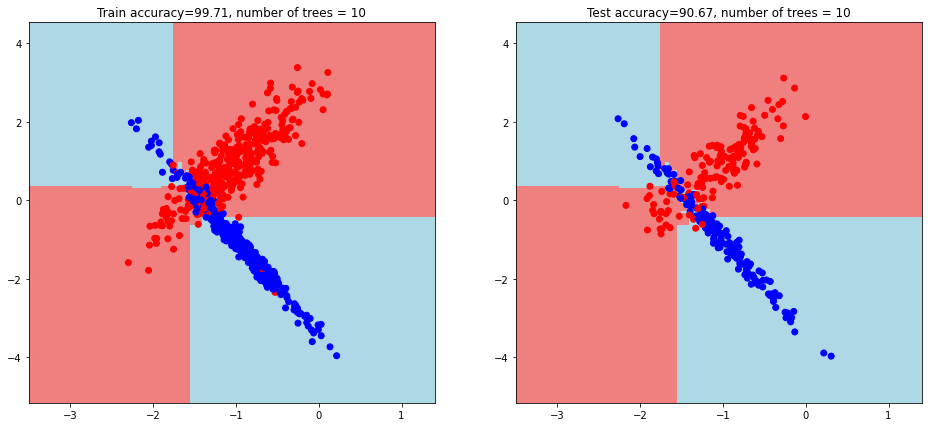

In [42]:
plot_forest(10)

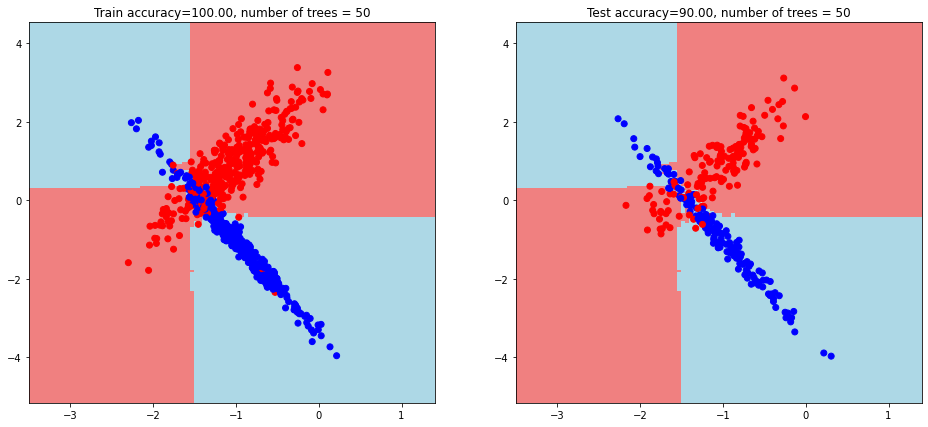

In [43]:
plot_forest(50)

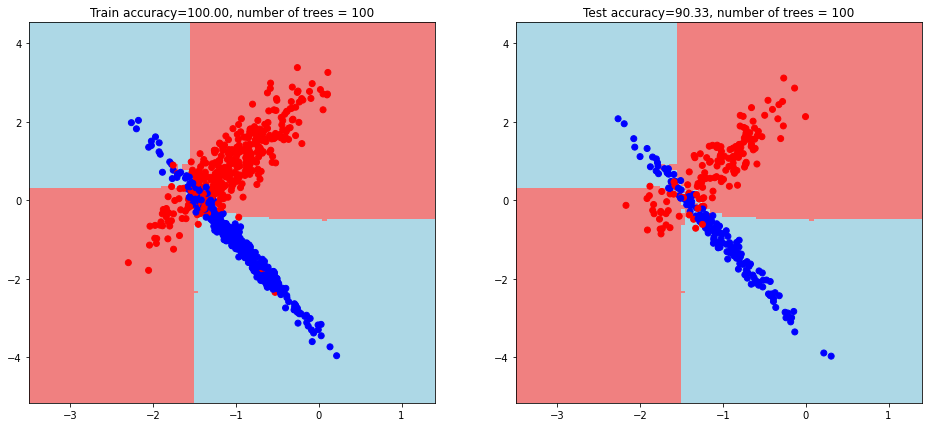

In [44]:
plot_forest(100)

## В данном примере увеличивать количество деревьев более 3 не имеет смысла

## Задание 2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag

## Задание 3. Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy

Функция расчета энтропии реализована в классе ForestTree.entropia

## Проверка алгоритма леса

### Исходные данные

In [23]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                                              n_features=2, n_informative=2,
                                                                              n_classes=2, n_redundant=0,
                                                                              n_clusters_per_class=1, random_state=23)
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                random_state=1)




### Мой алгоритм

In [24]:
n_trees = 10

my_forest_1 = RandomForest(n_trees=n_trees)
my_forest_1.fit(train_data, train_labels)
train_answers = my_forest_1.tree_vote(train_data)
test_answers = my_forest_1.tree_vote(test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print('\nRandom forest')
print(f' Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f' Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')





Random forest

 Точность случайного леса из 10 деревьев на обучающей выборке: 99.286
 Точность случайного леса из 10 деревьев на тестовой выборке: 90.333


### Алгоритм из sclearn

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf = RandomForestClassifier(random_state=0, n_estimators=n_trees)
clf.fit(train_data, train_labels)
sk_train_answers = clf.predict(train_data)
sk_test_answers = clf.predict(test_data)

# Точность на обучающей выборке
sk_train_accuracy = accuracy_metric(train_labels, sk_train_answers)
print('\nSklearn Random forest')
print(f' Точность случайного леса из {n_trees} деревьев на обучающей выборке: {sk_train_accuracy:.3f}')

# Точность на тестовой выборке
sk_test_accuracy = accuracy_metric(test_labels, sk_test_answers)
print(f' Точность случайного леса из {n_trees} деревьев на тестовой выборке: {sk_test_accuracy:.3f}')






Random forest

 Точность случайного леса из 10 деревьев на обучающей выборке: 99.571
 Точность случайного леса из 10 деревьев на тестовой выборке: 90.333


In [45]:
for n in np.array([1, 2, 5, 10, 20, 50, 100, 200]):
    my_forest_1 = RandomForest(n_trees=n)
    my_forest_1.fit(train_data, train_labels)
    train_answers = my_forest_1.tree_vote(train_data)
    test_answers = my_forest_1.tree_vote(test_data)

    print(f'\nNumber of trees: {n}')
    
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print('My Random forest\t', end='')
    print(f'Train: {train_accuracy:.3f}\t', end='')

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Test: {test_accuracy:.3f}')

    clf = RandomForestClassifier(random_state=0, n_estimators=n)
    clf.fit(train_data, train_labels)
    sk_train_answers = clf.predict(train_data)
    sk_test_answers = clf.predict(test_data)

    # Точность на обучающей выборке
    sk_train_accuracy = accuracy_metric(train_labels, sk_train_answers)
    print('Sklearn Random forest\t', end='')
    print(f'Train: {sk_train_accuracy:.3f}\t', end='')

    # Точность на тестовой выборке
    sk_test_accuracy = accuracy_metric(test_labels, sk_test_answers)
    print(f'Test: {sk_test_accuracy:.3f}')


Number of trees: 1
My Random forest	Train: 96.286	Test: 89.333
Sklearn Random forest	Train: 95.429	Test: 90.000

Number of trees: 2
My Random forest	Train: 95.000	Test: 84.667
Sklearn Random forest	Train: 96.000	Test: 89.000

Number of trees: 5
My Random forest	Train: 99.000	Test: 91.333
Sklearn Random forest	Train: 98.857	Test: 90.667

Number of trees: 10
My Random forest	Train: 99.286	Test: 89.667
Sklearn Random forest	Train: 99.571	Test: 90.333

Number of trees: 20
My Random forest	Train: 99.857	Test: 90.000
Sklearn Random forest	Train: 99.857	Test: 91.333

Number of trees: 50
My Random forest	Train: 100.000	Test: 90.000
Sklearn Random forest	Train: 100.000	Test: 91.667

Number of trees: 100
My Random forest	Train: 100.000	Test: 91.000
Sklearn Random forest	Train: 100.000	Test: 91.667

Number of trees: 200
My Random forest	Train: 100.000	Test: 90.333
Sklearn Random forest	Train: 100.000	Test: 92.000
